In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import optimize as optim

import sympy
from sympy.solvers import solve

%matplotlib notebook

In [2]:
FontSize = 18
plt.rc('axes',   titlesize = FontSize) # fontsize of the axes title
plt.rc('axes',   labelsize = FontSize) # fontsize of the x and y labels
plt.rc('xtick',  labelsize = FontSize) # fontsize of the tick labels
plt.rc('ytick',  labelsize = FontSize) # fontsize of the tick labels
plt.rc('legend', fontsize  = FontSize) # legend fontsize
plt.rc('figure', titlesize = FontSize) # fontsize of the figure title

matplotlib.rcParams.update({
    'font.family': 'serif',
    'font.size' :  18,
    'text.usetex': True,
    'pgf.rcfonts': False,
})

## Meniscus

d = 370.80992435478316


<IPython.core.display.Javascript object>


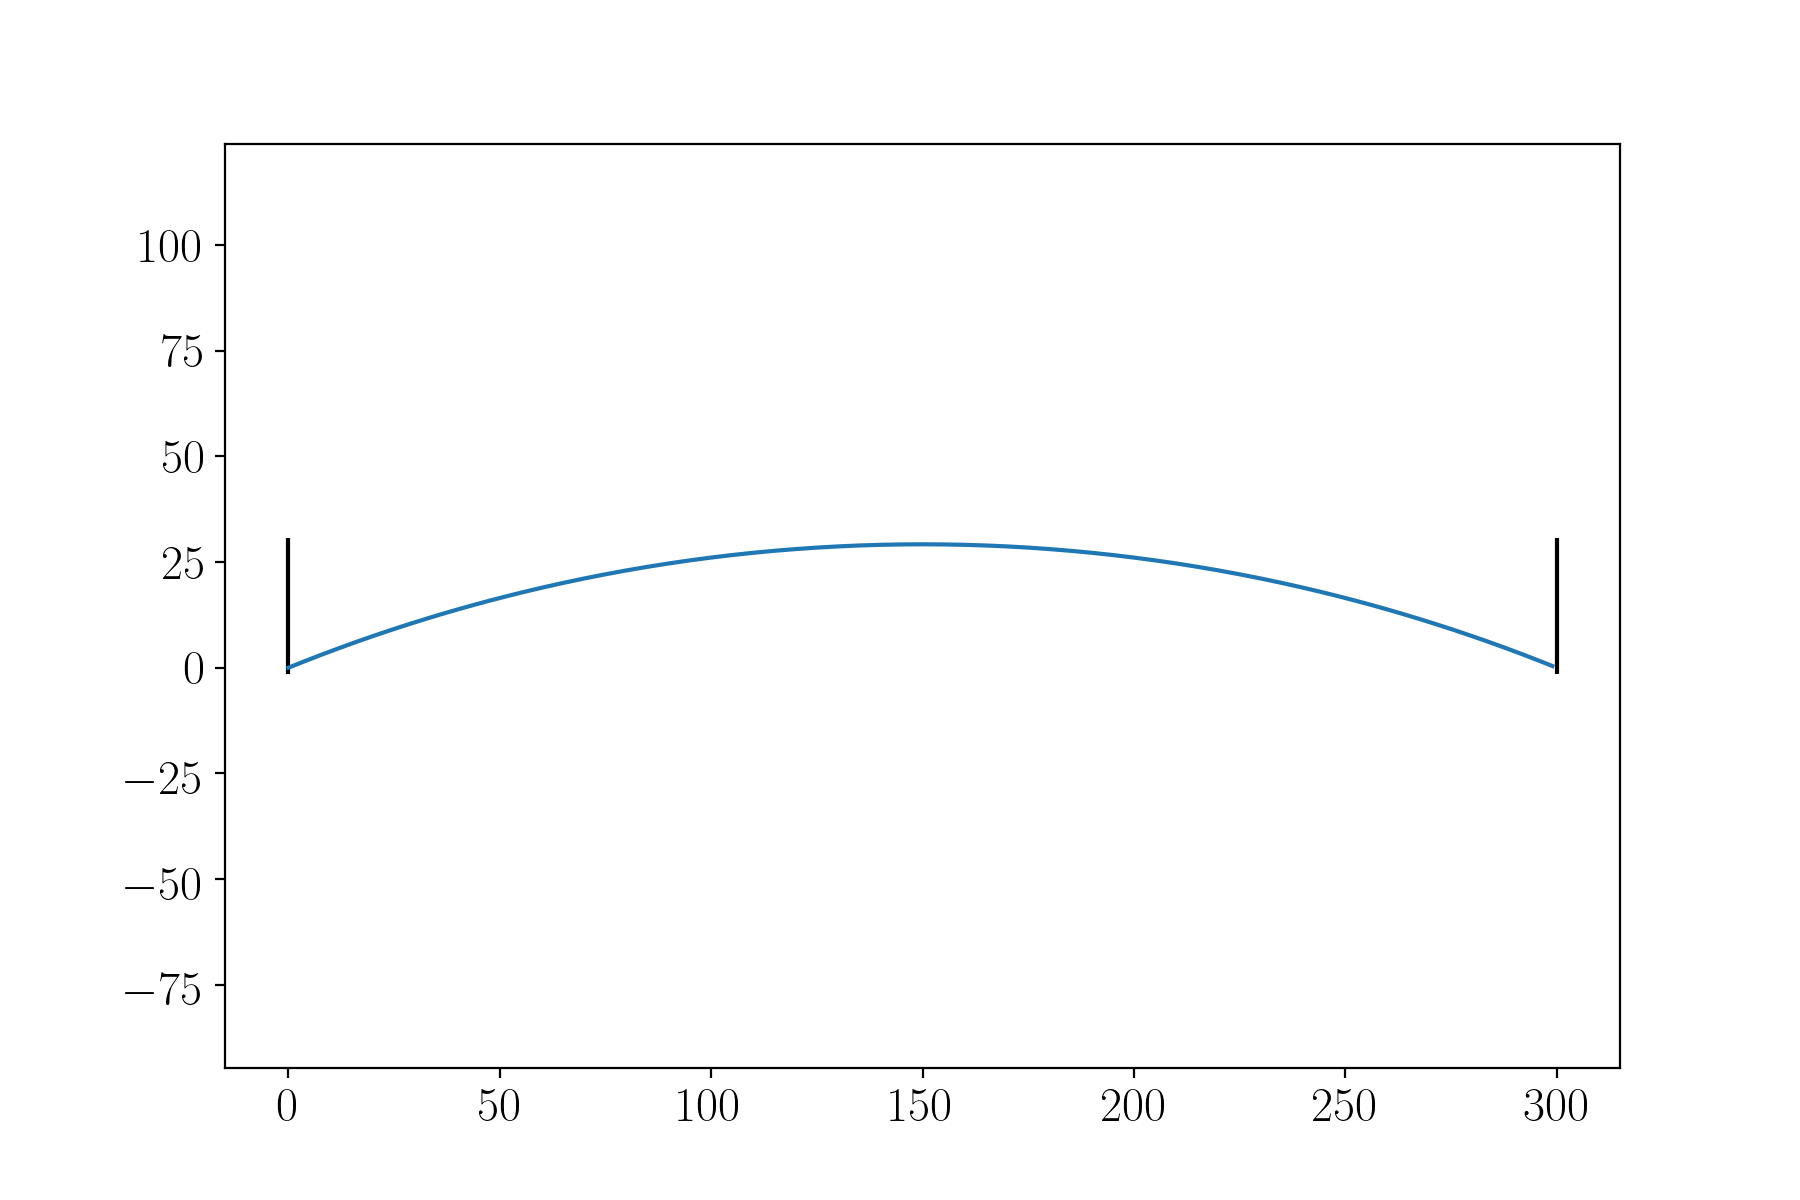

(-3.064957942747768, 32.255033587964604)

In [125]:
t = 300 # inner thickness of the capillary

R = 400 # menisc curvature radius

n_c = 1.3
n_o = 1.1
n_w = 1.33

d = np.sqrt(R**2 - 0.25*t**2)
print(f'{d = }')

min_theta_n = np.arctan(2*d/t)

ys = np.arange(-d/4 - 1, R - d + 1, 1)
xs = np.arange(0,t, 1)

def interface_y(x):
    return np.sqrt(R**2 - (x - t/2)**2) - d


fig,ax = plt.subplots(figsize=(9,6))
ax.axis('equal')
plt.plot(xs, interface_y(xs))
plt.vlines([0,t], *ax.get_ylim())
plt.xlim(*ax.get_xlim())
plt.ylim(*ax.get_ylim())

In [87]:
def interface(y):
    '''
    given y returns the first intersection point and incidence angle, if found
    '''
    if y < 0 or y >= R - d:
        return (None, None)
    
    theta_1 = np.arcsin((d + y)/R)
    x1 = t/2 - R*np.cos(theta_1)
    return x1

def reflectance(theta_i,n,polarization='p'):
    if theta_i > np.pi/2:
        theta_i = np.pi - theta_i
        
    q = np.sin(theta_i)/n
    if q > 1:
        #total reflection
        return 1.
    theta_t = np.arcsin(q)
    
    r = 0.
    if polarization == 'p':
        r = (-n*np.cos(theta_i) + np.cos(theta_t))/(n*np.cos(theta_i) + np.cos(theta_t))
    else:
        r = (np.cos(theta_i) - n*np.cos(theta_t))/(np.cos(theta_i) + n*np.cos(theta_t))
    return r**2

def transmittance(theta_i,n,polarization='p'):
    return 1. - reflectance(theta_i,n,polarization)

class interface_point():
    def __init__(self,x, theta_in_abs = 0, polarization = 'p'):
        self.x = x
        self.y = interface_y(x)
        self.normal_theta = np.arccos((self.x - t/2)/R)
        
        self.theta_in = self.normal_theta - theta_in_abs
        
        #refractive indeces
        # beam comes form water
        self.n = n_o/n_w
        self.theta_t = np.arcsin(np.sin(self.theta_in)/self.n)
        
        if self.theta_in > 0.5*np.pi:
            # beam comes from oil
            self.n = 1/self.n
            self.theta_t = np.pi - np.arcsin(np.sin(self.theta_in)/self.n)
            
        self.theta_r_abs = 2*self.theta_in + theta_in_abs - np.pi
        
        self.theta_t_abs = self.normal_theta - self.theta_t
        
        if np.sin(self.theta_in)/self.n > 1:
            self.theta_t = None
            self.theta_t_abs = None
        
        #Reflectance and Transmittance
        # for now assume equal split
        self.R = reflectance(self.theta_in, self.n, polarization)
        self.T = 1. - self.R
        
        
class Ray():
    def __init__(self,y0,I0=1., polarization='p'):
        self.polarization = polarization
        self.rays = []
        self.intensities = []
        self.points = []
        self.final_ys = []
        self.final_Is = []
            
        if y0 < 0:
            # strainght ray in water
            self.rays.append(((0,t), (y0,y0)))
            I = I0*n_w/n_c*(2/(1 + n_w/n_c))**2
            self.intensities.append(I)
            self.final_Is.append(I*n_c/n_w*(2/(1 + n_c/n_w))**2)
            self.final_ys.append(y0)
            
        elif y0 > R - d:
            # strainght ray in oil
            self.rays.append(((0,t), (y0,y0)))
            I = I0*n_o/n_c*(2/(1 + n_o/n_c))**2
            self.intensities.append(I)
            self.final_Is.append(I*n_c/n_o*(2/(1 + n_c/n_o))**2)
            self.final_ys.append(y0)
            
        else:
            # more complicated problem
            I = I0*n_o/n_c*(2/(1 + n_o/n_c))**2
            self.intensities.append(I)
            x1 = interface(y0)
            self.rays.append(((0,x1), (y0,y0)))
            
            self.propagate(x1=x1,theta1=0, I=I)
            
        
        
    def propagate(self,x1, theta1, I):
        '''
        Assumes to start on impinging on the interface
        '''

        def conclude(theta_abs, y, I_coeff, n_hit=n_o):
            x2 = t
            y2 = y + (x2 - x1)*np.tan(theta_abs)
            self.rays.append(((x1,x2), (y,y2)))
            self.intensities.append(I_coeff*I)
            self.final_ys.append(y2)
            self.final_Is.append(I_coeff*I*transmittance(theta_i=theta_abs,
                                                         n=n_c/n_hit, polarization=self.polarization))


        p = interface_point(x1,theta1, polarization=self.polarization)
        self.points.append(p)

        if p.theta_t != None:
            if p.theta_t <= np.pi/2:
                # no more interactions with interface, path in oil
                conclude(theta_abs=p.theta_t_abs, y=p.y, I_coeff=p.T,n_hit=n_o)
            else:
                d_theta_n = 2*p.theta_t - np.pi
                theta_n = p.normal_theta - d_theta_n
                if theta_n < min_theta_n:
                    #no more interaction with interface, path in water
                    conclude(theta_abs=p.theta_t_abs, y=p.y, I_coeff=p.T, n_hit=n_w)
                else:
                    x2 = t/2 + R*np.cos(theta_n)
                    y2 = p.y + (x2 - x1)*np.tan(p.theta_t_abs)
                    self.rays.append(((x1,x2), (p.y,y2)))
                    self.intensities.append(p.T*I)

                    self.propagate(x1=x2, theta1=p.theta_t_abs, I=p.T*I)

        if p.theta_in >= np.pi/2:
            # no more interactions with interface, path in oil
            conclude(theta_abs=p.theta_r_abs, y=p.y, I_coeff=p.R, n_hit=n_o)
        else:
            d_theta_n = np.pi - 2*p.theta_in
            theta_n = p.normal_theta - d_theta_n
            if theta_n < min_theta_n:
                #no more interaction with interface, path in water
                conclude(theta_abs=p.theta_r_abs, y=p.y, I_coeff=p.R, n_hit=n_w)
            else:
                x2 = t/2 + R*np.cos(theta_n)
                y2 = p.y + (x2 - x1)*np.tan(p.theta_r_abs)
                self.rays.append(((x1,x2), (p.y,y2)))
                self.intensities.append(p.T*I)

                self.propagate(x1=x2, theta1=p.theta_r_abs, I=p.R*I)




In [121]:
ray1 = Ray(10,polarization='s')
print(f'{ray1.rays = }\n{ray1.final_ys = }\n{ray1.final_Is = }')

print(f'\n\nTotal intensity reaching the end: {np.sum(ray1.final_Is)}')

ray1.rays = [((0, 27.59166077058177), (10, 10)), ((27.59166077058177, 300), (10.0, 205.3071261702406))]
ray1.final_ys = [205.3071261702406]
ray1.final_Is = [0.8689344146478809]


Total intensity reaching the end: 0.8689344146478809


<ipython-input-87-76fcae50842c>:48: RuntimeWarning: invalid value encountered in arcsin
  self.theta_t = np.pi - np.arcsin(np.sin(self.theta_in)/self.n)


In [103]:
for ray in ray1.rays:
    plt.plot(ray[0],ray[1])


<IPython.core.display.Javascript object>


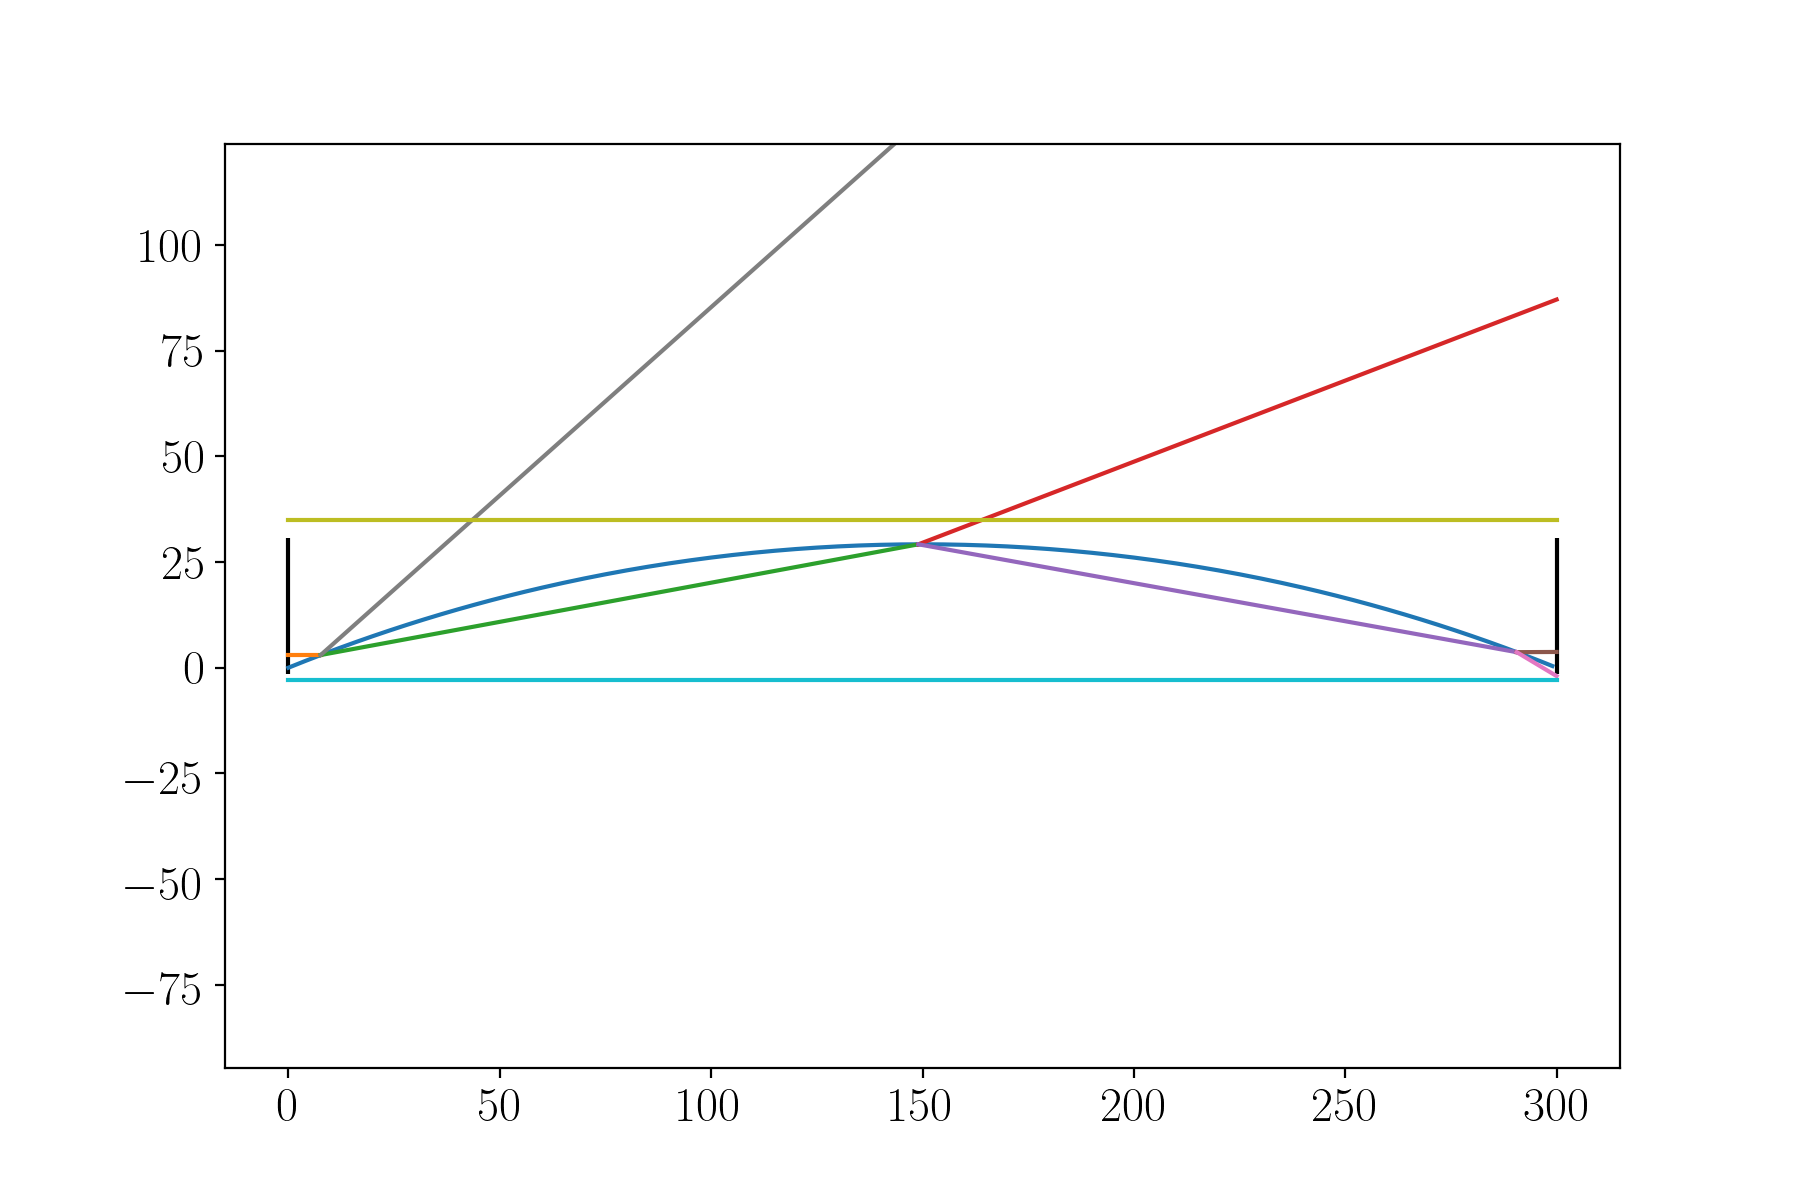

(-3.064957942747768, 32.255033587964604)

In [96]:
fig,ax = plt.subplots(figsize=(9,6))
ax.axis('equal')
plt.plot(xs, interface_y(xs))
plt.vlines([0,t], *ax.get_ylim())
plt.xlim(*ax.get_xlim())
plt.ylim(*ax.get_ylim())

In [134]:
y0s = np.arange(-1,32,0.1)

rays_p = []
rays_s = []
for y0 in y0s:
    rays_p.append(Ray(y0, polarization='p'))
    rays_s.append(Ray(y0, polarization='s'))

<ipython-input-87-76fcae50842c>:43: RuntimeWarning: invalid value encountered in arcsin
  self.theta_t = np.arcsin(np.sin(self.theta_in)/self.n)


<IPython.core.display.Javascript object>


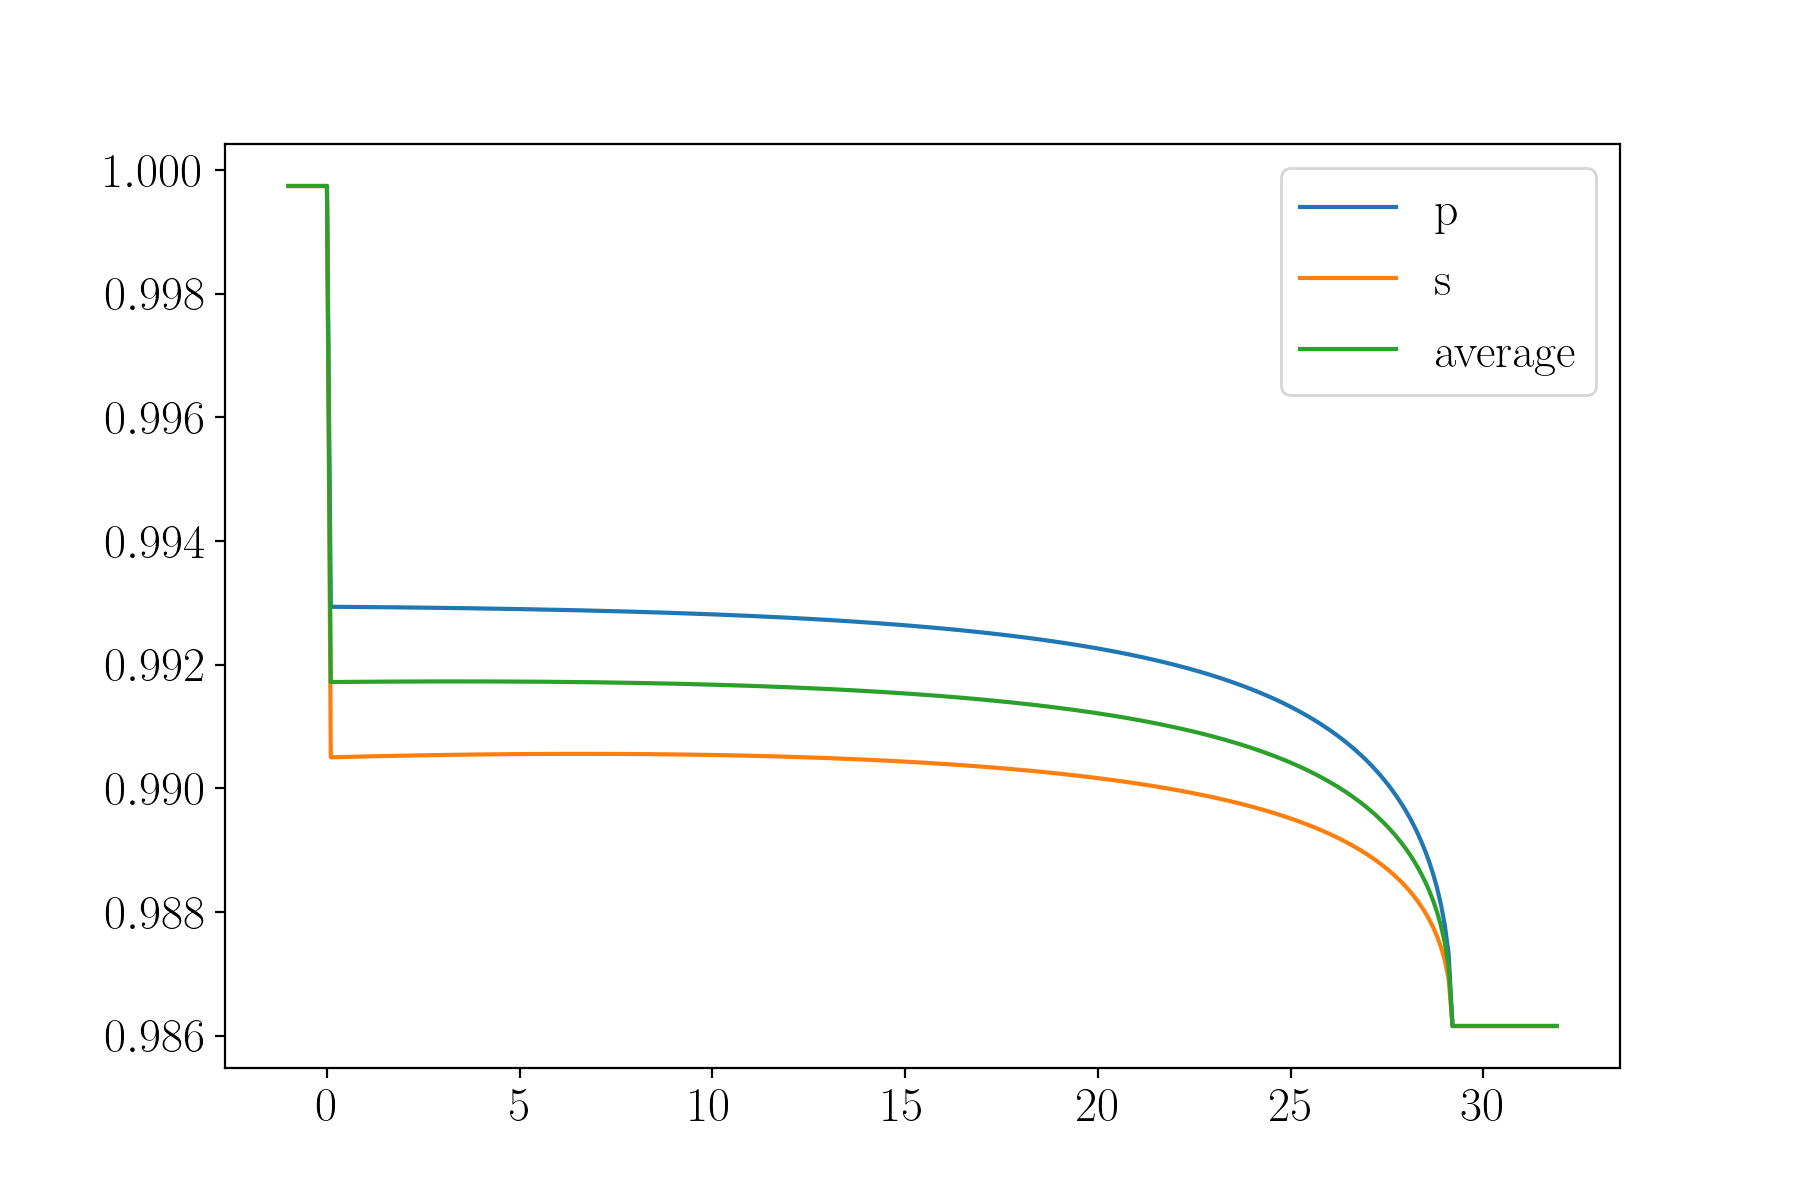

In [135]:
plt.figure(figsize=(9,6))

I_p = np.array([np.sum(r.final_Is) for r in rays_p])
I_s = np.array([np.sum(r.final_Is) for r in rays_s])

plt.plot(y0s, I_p, label='p')
plt.plot(y0s, I_s, label='s')
plt.plot(y0s, 0.5*(I_p + I_s), label='average')
plt.legend()

In [140]:
collection_tolerance = 100


I_p_constrained = []

for i,r in enumerate(rays_p):
    I_c = 0.
    for j,I in enumerate(r.final_Is):
        if np.abs(r.final_ys[j] - y0s[i]) < collection_tolerance:
            I_c += I
    I_p_constrained.append(I_c)
    
I_p_constrained = np.array(I_p_constrained)

I_s_constrained = []

for i,r in enumerate(rays_s):
    I_c = 0.
    for j,I in enumerate(r.final_Is):
        if np.abs(r.final_ys[j] - y0s[i]) < collection_tolerance:
            I_c += I
    I_s_constrained.append(I_c)
    
I_s_constrained = np.array(I_s_constrained)

<IPython.core.display.Javascript object>


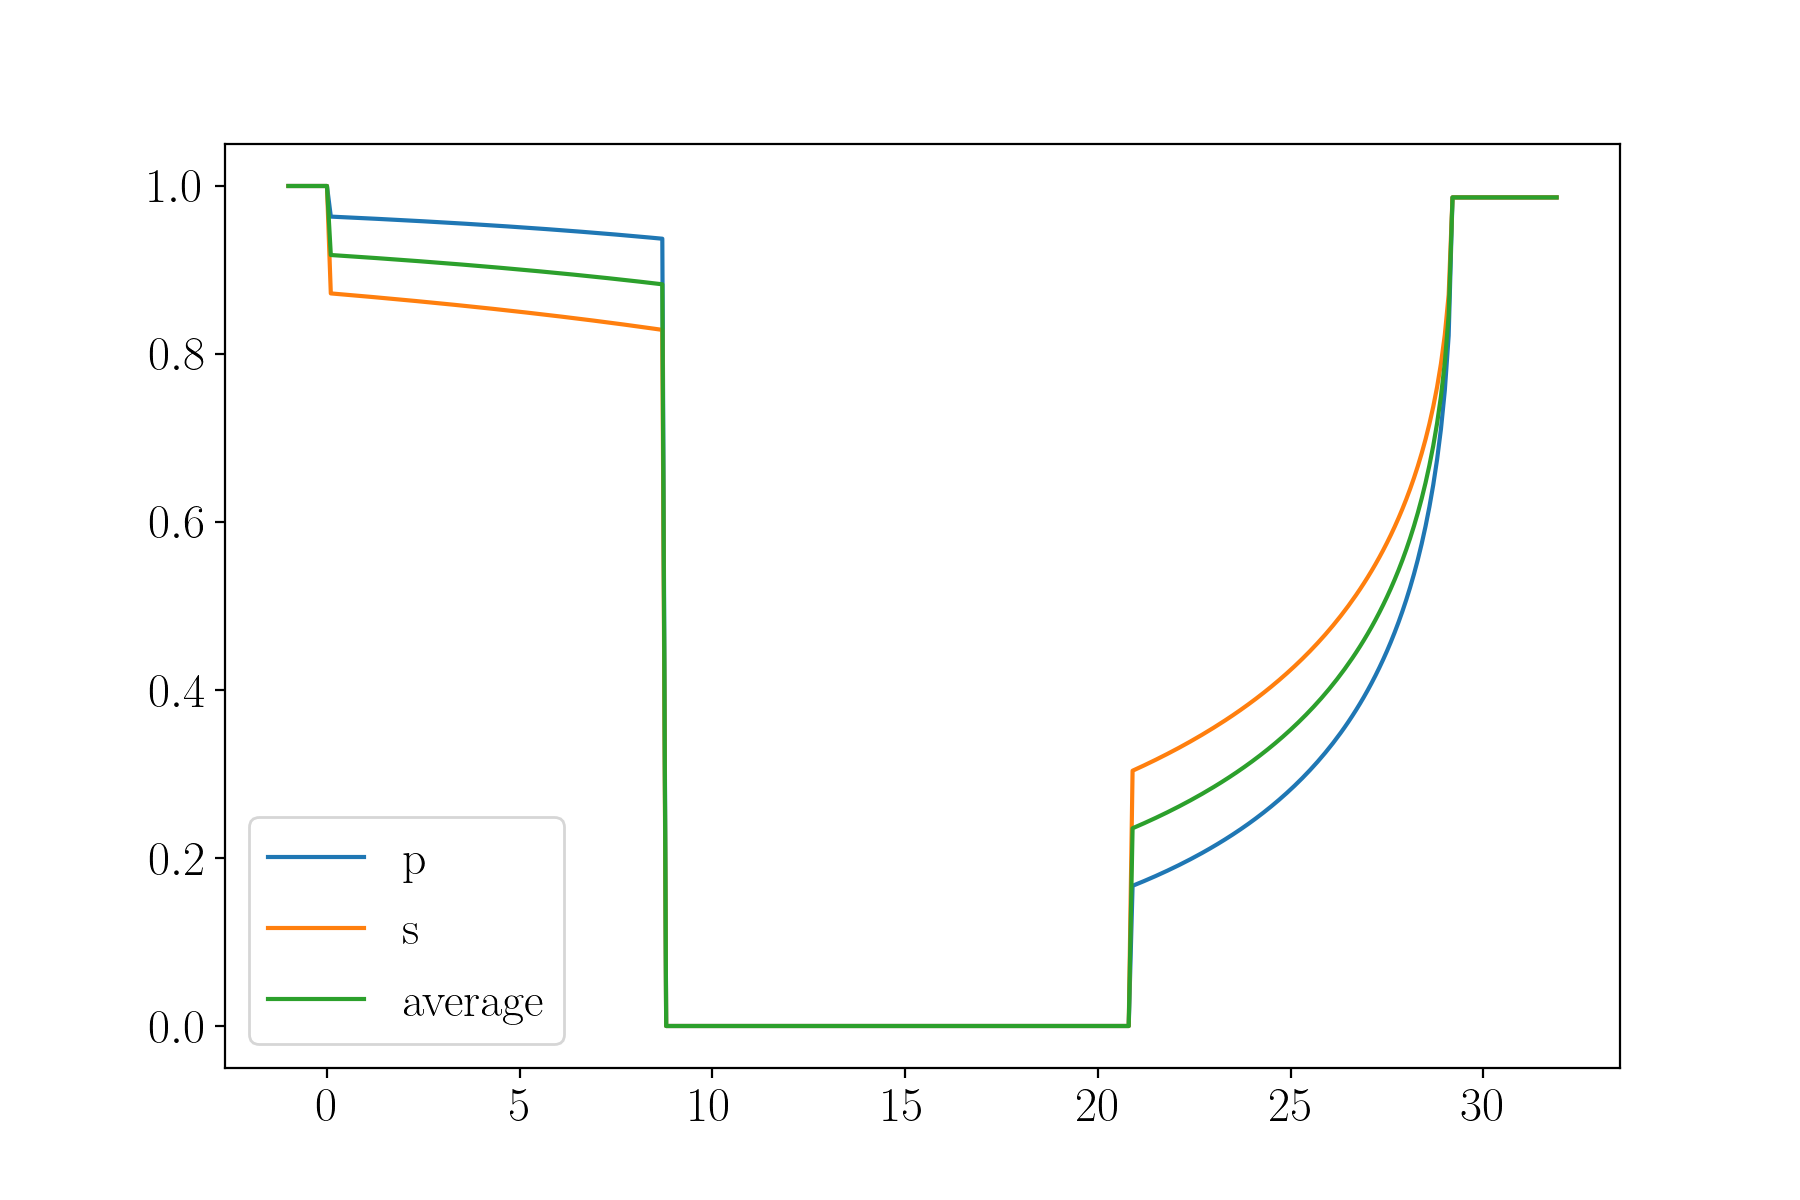

In [141]:
plt.figure(figsize=(9,6))
plt.plot(y0s, I_p_constrained, label='p')
plt.plot(y0s, I_s_constrained, label='s')
plt.plot(y0s, 0.5*(I_p_constrained + I_s_constrained), label='average')
plt.legend()

## Circularity of the capillary

In [37]:
R1 = 300
R2 = 150

def trace(b, extension=20, n0=1., n1=1.5, n2=1., allow_capillary_avoidance=True, verbose=False):
    
    if b < 0:
        points, thetaf = trace(-b, extension=extension, n0=n0, n1=n1, n2=n2,
                               allow_capillary_avoidance=allow_capillary_avoidance, verbose=verbose)
        points[:,1] *= -1
        thetaf *= -1
        return points, thetaf
    
    points = []
    points.append([-R1 - extension, b])
    if np.abs(b) > R1:
        if allow_capillary_avoidance:
            points.append([R1 + extension, b])
            if verbose:
                print('No interaction')
            return np.array(points), 0
        else:
            if verbose:
                print('No interaction')
            return np.array(points), np.nan
    
    
    theta0 = np.arcsin(b/R1)
    x1 = -R1*np.cos(theta0)
    y1 = b
    
    points.append([x1, y1])
    
    q = n0/n1*np.sin(theta0)
    if q > 1:
        if verbose:
            print('Total reflection')
        return np.array(points), np.nan
    theta1 = np.arcsin(q)
    m = np.tan(theta1 - theta0)
    
    x = sympy.Symbol('x')
    
    sol = solve((y1 + m*(x - x1))**2 - (R2**2 - x**2), x)
    x2 = complex(sol[0])
    if np.imag(x2) != 0:
        # no interaction with the inner circle
        alpha2 = theta0 + np.pi - 2*theta1
        x2 = -R1*np.cos(alpha2)
        y2 = R1*np.sin(alpha2)
        
        points.append([x2,y2])
        
        thetaf_rel = theta0
        thetaf = np.pi - alpha2 - thetaf_rel
        
        yf = y2 + np.tan(thetaf)*(R1 + extension - x2)
        points.append([R1 + extension, yf])
        return np.array(points), thetaf
    
    
    x2 = np.real(x2)
    y2 = y1 + m*(x2 - x1)
    points.append([x2, y2])
    alpha2 = np.arccos(-x2/R2)
    
#     print(f'{alpha2 = }')
    
    theta2 = theta1 + alpha2 - theta0
    
    q = n1/n2*np.sin(theta2)
    if q > 1:
        if verbose:
            print('Total reflection')
        return np.array(points), np.nan
    theta3 = np.arcsin(q)
    
    alpha3 = alpha2 + np.pi - 2*theta3
#     print(f'{alpha3 = }')
    
    x3 = -R2*np.cos(alpha3)
    y3 = R2*np.sin(alpha3)
    points.append([x3,y3])
    
    alpha4 = alpha3 + alpha2 - theta0
    x4 = -R1*np.cos(alpha4)
    y4 = R1*np.sin(alpha4)
    points.append([x4,y4])
    
    thetaf_rel = theta0
    thetaf = np.pi - alpha4 - thetaf_rel
    
    yf = y4 + np.tan(thetaf)*(R1 + extension - x4)
    points.append([R1 + extension, yf])
    return np.array(points), thetaf
    

<IPython.core.display.Javascript object>


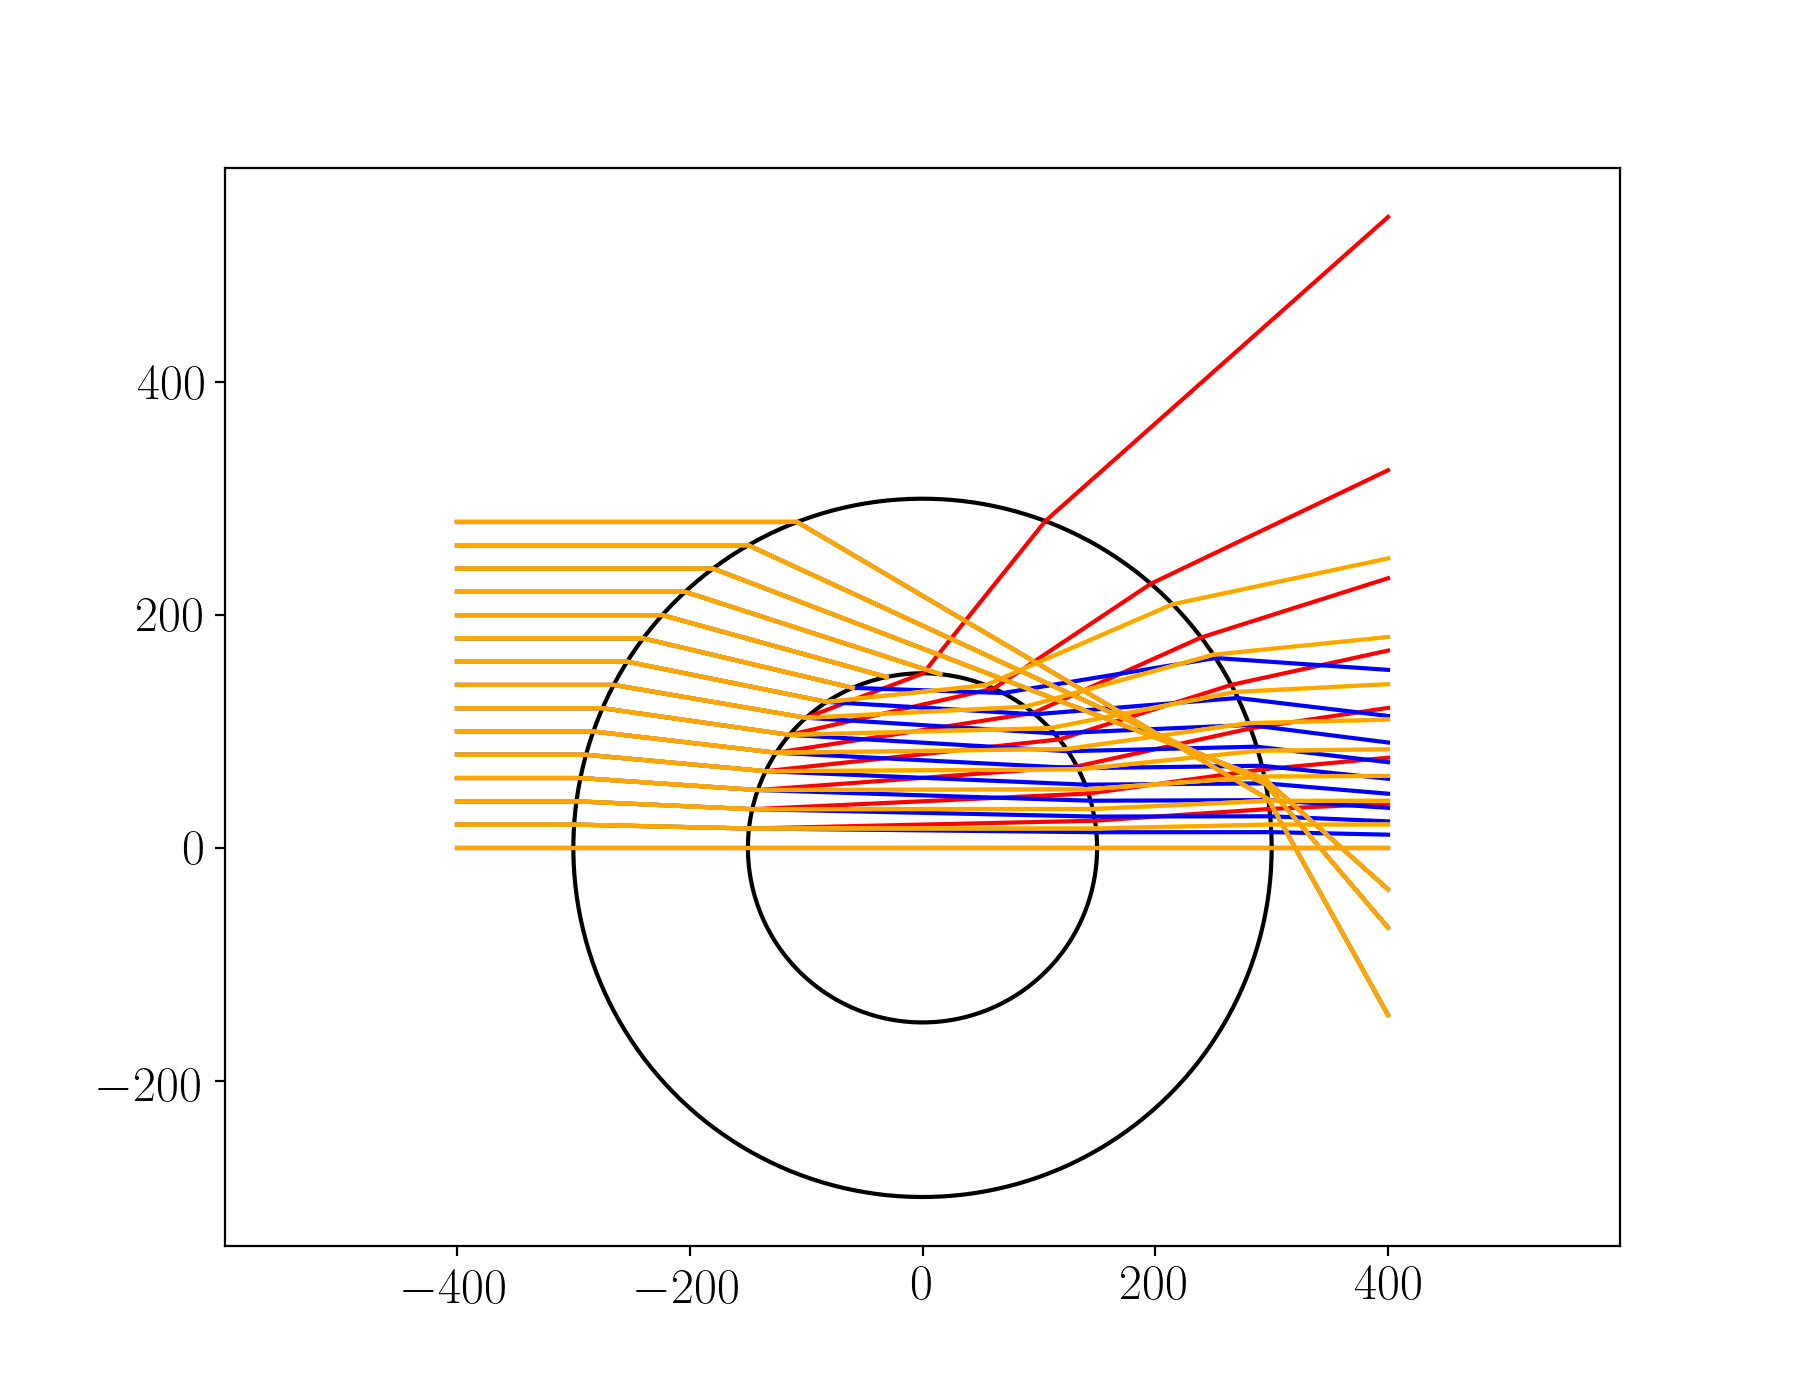

In [117]:
%matplotlib notebook
fig,ax = plt.subplots(figsize=(9,7))
ax.axis('equal')

alphas = np.linspace(0,2*np.pi, 200)
plt.plot(R1*np.cos(alphas), R1*np.sin(alphas), color='black')
plt.plot(R2*np.cos(alphas), R2*np.sin(alphas), color='black')



In [121]:
for b in np.arange(0, 300, 20):
    points, thetaf = trace(b,n2=1.2, extension=100)
    plt.plot(points[:,0], points[:,1], color='orange')

### Collected intensity

In [138]:
R_f = 500 # radius of the optical fiber

n1 = 1.6
n2 = 1.2
extension = 400

v_offset = 0

v_step = 5 # for simulating rays

theta_max = np.pi/10

v_misalignment = 0
h_misalignment = 0

v_misalignment += v_offset


ys = np.arange(-R_f, R_f + v_step, v_step)
intensities = 2*np.sqrt(R_f**2 - ys**2)
bs = ys + v_offset

I_in = np.sum(intensities)

end_points = []
end_thetas = []
valid_indices = []

for i,b in enumerate(bs):
    points, thetaf = trace(b, n1=n1, n2=n2, extension=extension, allow_capillary_avoidance=False)
    if np.isfinite(thetaf):
        end_points.append(points[-1][1])
        end_thetas.append(thetaf)
        valid_indices.append(i)
    else:
        end_points.append(np.nan)
        end_thetas.append(np.nan)

valid_indices = np.array(valid_indices)
end_points = np.array(end_points)[valid_indices]
end_thetas = np.array(end_thetas)[valid_indices]
end_intensities = intensities[valid_indices]


I_out = 0
v_indices = []

for i,b in enumerate(end_points):
    if np.abs(b - v_misalignment) > R_f:
        continue
    if np.abs(end_thetas[i]) > theta_max:
        continue
    v_indices.append(i)
    I1 = end_intensities[i]
    I2 = 2*np.sqrt(R_f**2 - (b - v_misalignment)**2)
    
    I = np.min([I1, I2 - h_misalignment])
    I_out += np.max([I, 0])
    
print(f'Collected {I_out/I_in*100}% of the incoming light')

Collected 39.00272219181961% of the incoming light


<IPython.core.display.Javascript object>


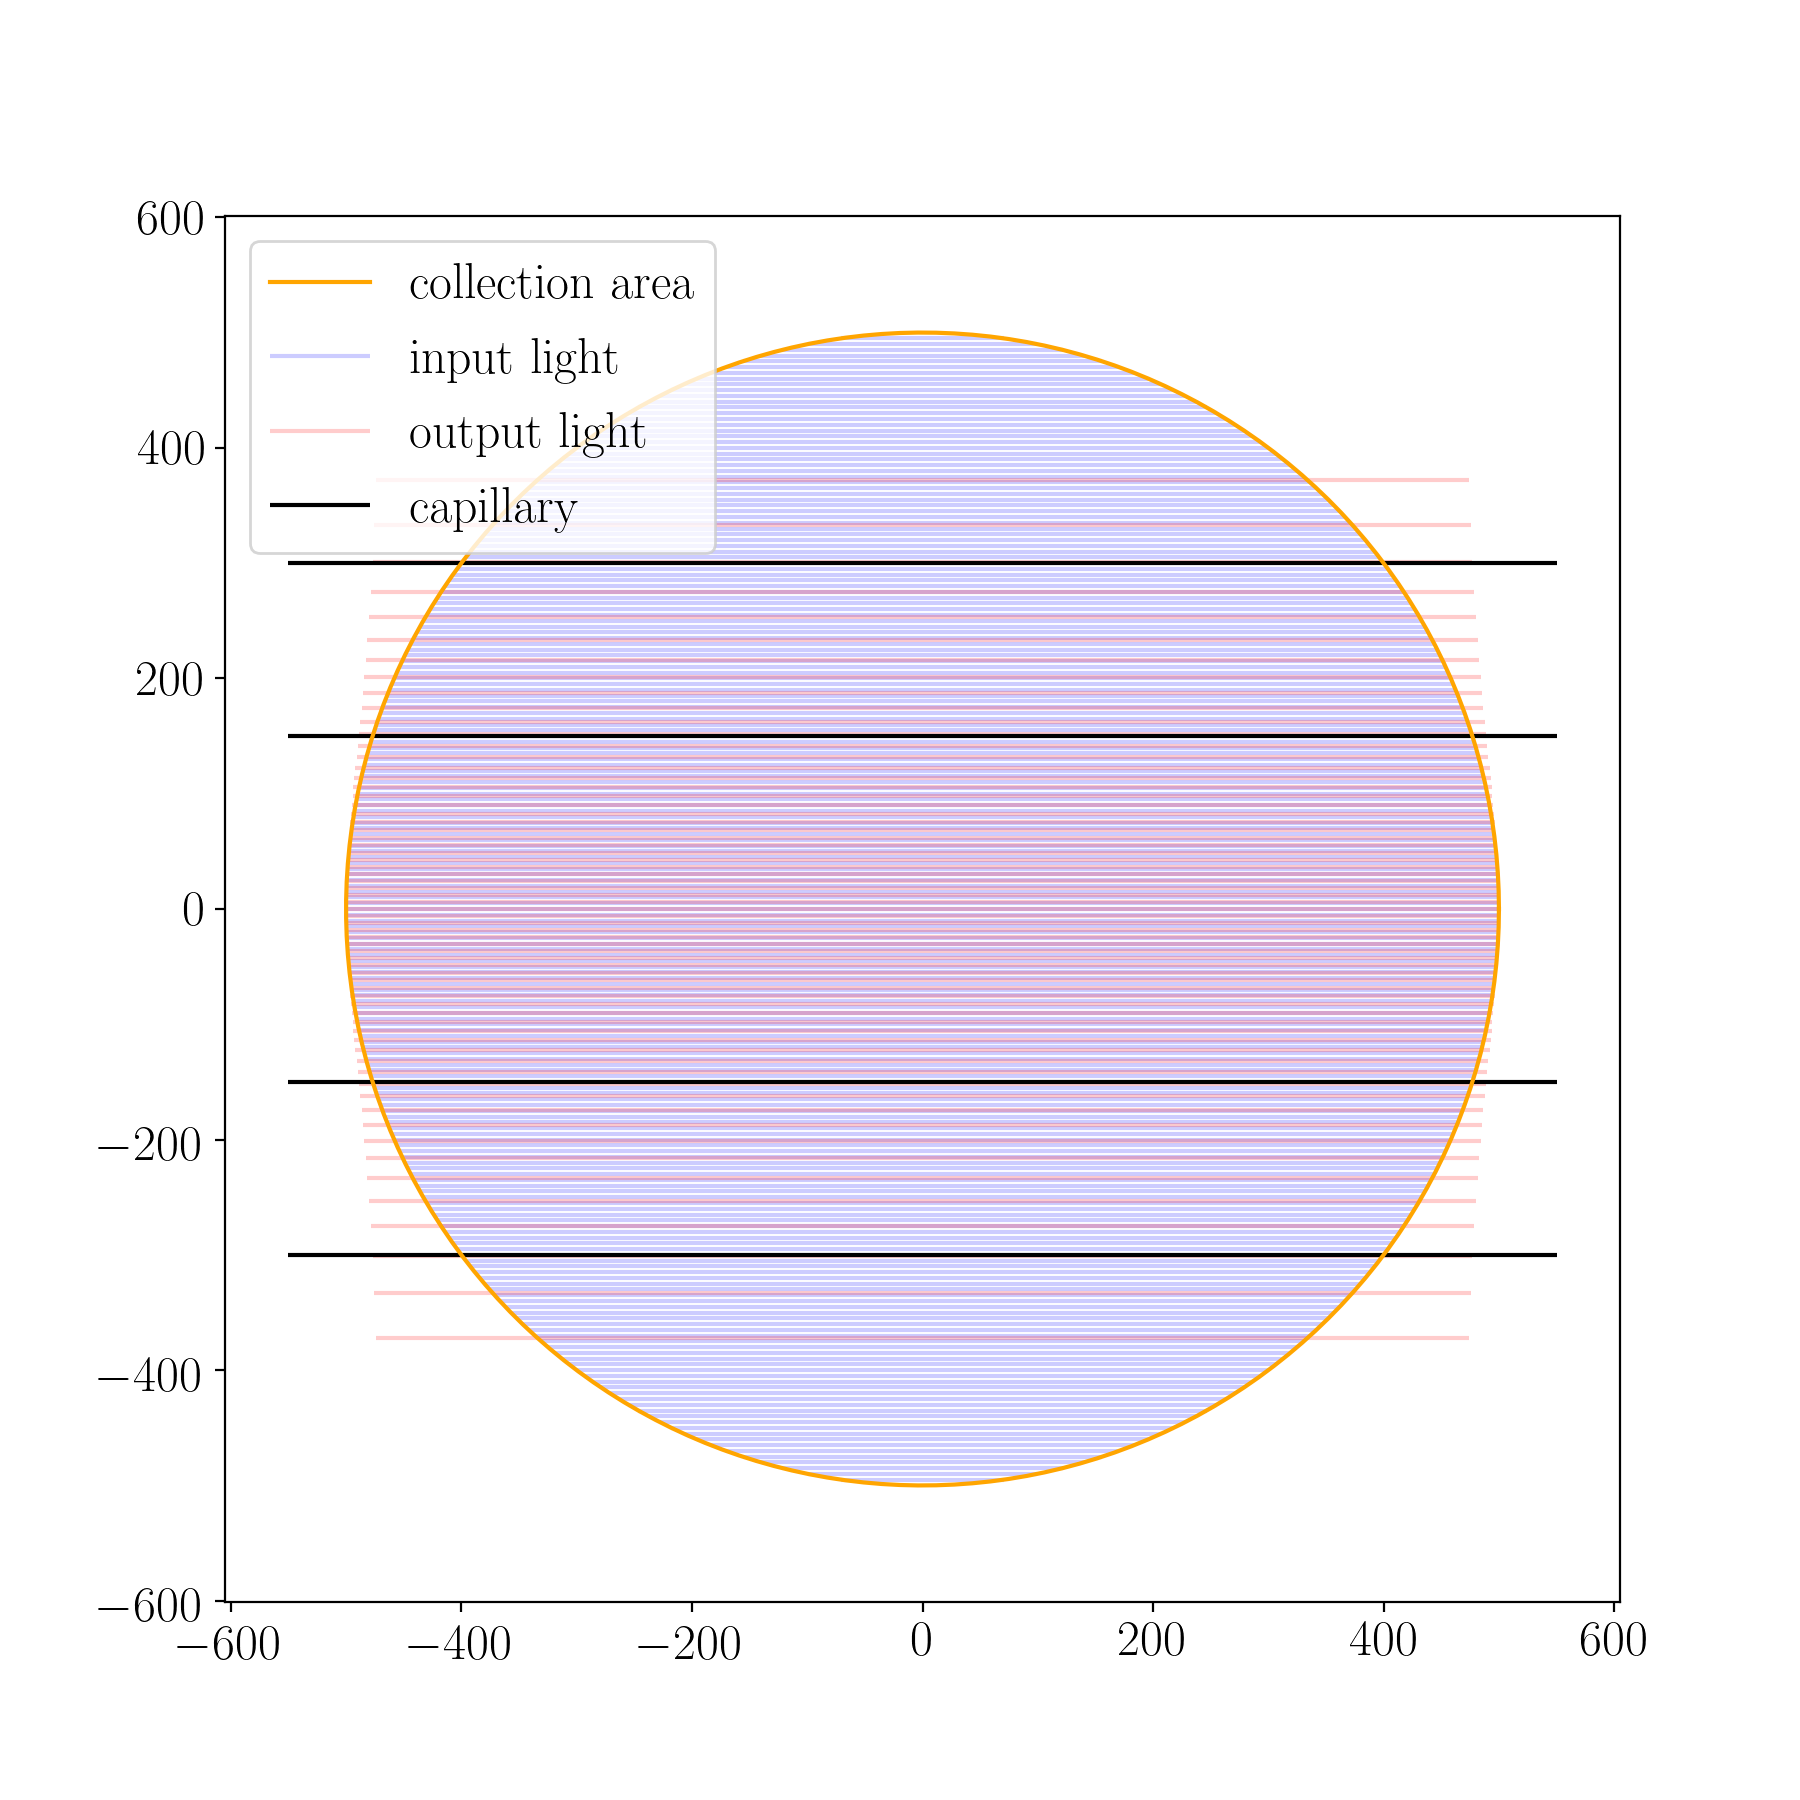

In [139]:
fig, ax = plt.subplots(figsize = (9,9))
ax.axis('equal')

label = 'input light'
for i,b in enumerate(bs):
    plt.hlines([b], *(np.array([-0.5,0.5])*intensities[i]), color='blue', alpha = 0.2, label=label)
    label = None

label = 'output light'
for i,b in enumerate(end_points[v_indices]):
    plt.hlines([b], *(np.array([-0.5,0.5])*end_intensities[v_indices][i]),
               color='red', alpha=0.2, label=label)
    label = None

plt.hlines([-R1, -R2, R2, R1], *ax.get_xlim(), color='black', alpha=1, label='capillary')

plt.plot(h_misalignment + R_f*np.cos(alphas), v_misalignment + R_f*np.sin(alphas),
         color='orange', label='collection area')

plt.legend(loc='upper left')